# Linearly decoded VAE

This notebook shows how to use the 'linearly decoded VAE' model which explicitly links latent variables of cells to genes.

The scVI package learns low-dimensional latent representations of cells which get mapped to parameters of probability distributions which can generate counts consistent to what is observed from data. In the standard `VAE` model of scVI these parameters for each gene and cell arise from applying neural networks to the latent variables. Neural networks are flexible and can represent non-linearities in the data. This comes at a price, there is no direct link between a latent variable dimension and any potential set of genes which would covary across it.

The `LDVAE` model replaces the neural networks with linear functions. Now a higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.

This leads to a generative model comparable to probabilistic PCA or factor analysis, but generates counts rather than real numbers. Using the framework of scVI also allows variational inference which scales to very large datasets and can make use of GPUs for additional speed.

This notebook demonstrates how to fit an `LDVAE` model to scRNA-seq data, plot the latent variables, and interpret which genes are linked to latent variables.

As an example, we use the PBMC 3K from 10x Genomics. This data is also used in the [Seurat tutorial for PCA](https://satijalab.org/seurat/v3.0/pbmc3k_tutorial.html), and we can compare the results here with those results.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Automated testing configuration

In [3]:
import os 

def allow_notebook_for_test():
    print("Testing the ldvae notebook")


test_mode = False
save_path = "data/"
n_epochs_all = None


if not test_mode:
    save_path = "../../data"
    
data_path = os.path.join(save_path, "filtered_gene_bc_matrices/hg19/")

C:\Users\vale\Documents\GitHub\scVI


In [2]:
import torch

from scvi.dataset import GeneExpressionDataset, AnnDatasetFromAnnData
from scvi.models import LDVAE
from scvi.inference import UnsupervisedTrainer, Trainer
from scvi.inference.posterior import Posterior

import pandas as pd
import anndata
import scanpy as sc

import matplotlib.pyplot as plt

# Initialization

In [6]:
# Uncomment to download the data (only works on Unix system)

# cd ../../
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

In [5]:
import torch
import numpy as np

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In the following few cells we convert the downloaded data to [AnnData](https://anndata.readthedocs.io/en/latest/), which is a convenient format to keep track of scRNA-seq data.

In [8]:
# Load the data
adata = sc.read_10x_mtx(
    os.path.join(
        save_path, "filtered_gene_bc_matrices/hg19/"
    ),  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
)
adata.var_names_make_unique()

To train scVI models, we need `GeneExpressionDataset`s. So we also copy the data from the AnnData object to this object using `AnnDatasetFromAnnData`

In [12]:
cells_dataset = AnnDatasetFromAnnData(adata)

# Create and fit `LDVAE` model

First subsample 1,000 genes from the original data.

Then we initialize an `LDVAE` model and a `Trainer` for that model. Here we set the latent space to have 10 dimensions.

In [14]:
cells_dataset.subsample_genes(1000)

Downsampling from 32738 to 1000 genes
Downsampling from 2700 to 2700 cells


In [15]:
vae = LDVAE(cells_dataset.nb_genes,
            n_batch=cells_dataset.n_batches,
            n_latent=10,
            n_layers=1,
            n_hidden=128,
            reconstruction_loss='nb'
           )

In [16]:
trainer = UnsupervisedTrainer(vae,
                              cells_dataset,
                              frequency=1,
                              use_cuda=True
                             )

Now train the model using the trainer, and inspect the convergence.

In [17]:
n_epochs = 50 if n_epochs_all is None else n_epochs_all
trainer.train(n_epochs=50)

training: 100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


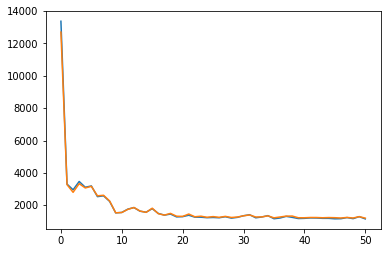

In [18]:
if not test_mode:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(trainer.history['ll_train_set'])
    ax.plot(trainer.history['ll_test_set']);

# Extract and plot latent dimensions for cells

From the fitted model we extract the (mean) values for the latent dimensions. We store the values in the AnnData object for convenience.

In [19]:
full = trainer.create_posterior(trainer.model, cells_dataset, indices=np.arange(len(cells_dataset)))
Z_hat = full.sequential().get_latent()[0]

In [20]:
for i, z in enumerate(Z_hat.T):
    adata.obs[f'Z_{i}'] = z

Now we can plot the latent dimension coordinates for each cell. A quick (albeit not complete) way to view these is to make a series of 2D scatter plots that cover all the dimensions. Since we are representing the cells by 10 dimensions, this leads to 5 scatter plots.

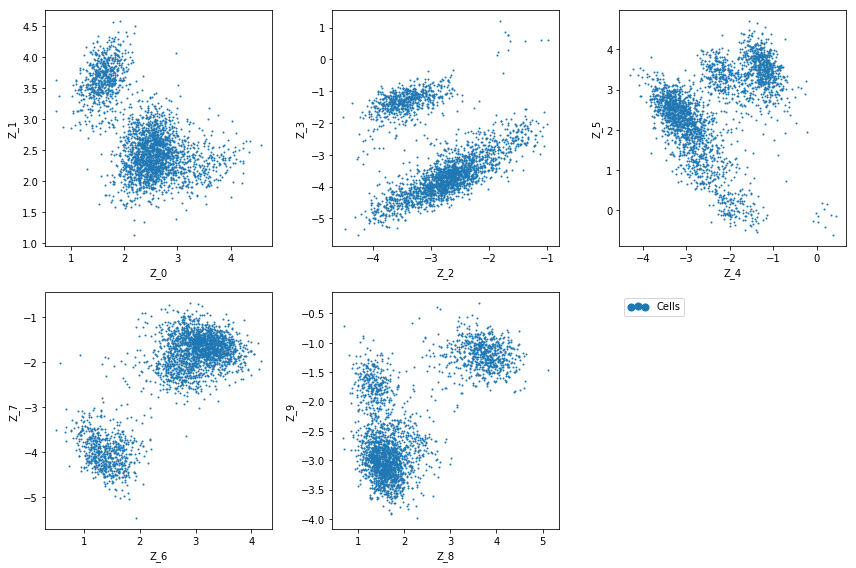

In [21]:
if not test_mode:
    figsize(12, 8)

    for f in range(0, 9, 2):
        plt.subplot(2, 3, int(f / 2) + 1)

        plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], marker='.', s=4, label='Cells')

        plt.xlabel(f'Z_{f}')
        plt.ylabel(f'Z_{f + 1}')

    plt.subplot(2, 3, 6)    
    plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], marker='.', label='Cells', s=4)
    plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], c='w', label=None)
    plt.gca().set_frame_on(False)
    plt.gca().axis('off')

    lgd = plt.legend(scatterpoints=3, loc='upper left')
    for handle in lgd.legendHandles:
        handle.set_sizes([200])


    plt.tight_layout()

We can see that cells cluster into at least three populations from these plots. The question now is how does the latent dimensions link to genes?

For a given cell x, the expression of the gene g is proportional to x_g = w_(1, g) * z_1 + ... + w_(10, g) * z_10. Moving from low values to high values in z_1 will mostly affect expression of genes with large w_(1, :) weights. We can extract these weights from the `LDVAE` model, and identify which genes have high weights for each latent dimension.

In [22]:
loadings = list(vae.decoder.factor_regressor.parameters())[0].cpu().detach().numpy()
loadings = \
pd.DataFrame.from_records(loadings, index=cells_dataset.gene_names,
                                    columns=[f'Z_{i}' for i in range(10)])

In [23]:
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9
FTL,0.047540,0.258600,-0.248338,0.262659,-0.303660,0.294451,-0.071931,-0.395350,-0.175477,0.107153
FTH1,0.242463,0.055966,-0.209980,-0.011523,-0.303477,-0.100718,-0.013364,-0.113856,0.388526,0.188770
MALAT1,0.008276,0.056811,-0.242808,-0.343540,-0.157479,-0.170210,0.169500,-0.233177,0.225488,-0.254253
TMSB4X,0.163900,0.015834,0.121903,-0.027864,-0.244127,0.014803,0.315155,-0.377983,0.321016,-0.192079
B2M,0.083990,0.415512,-0.255276,-0.131632,-0.162790,-0.201846,0.275357,0.103262,0.212225,-0.292175


For every latent variable Z, we extract the genes with largest _magnitude_, and separate genes with large negative values from genes with large positive values. We print out the top 5 genes in each direction for each latent variable.

In [24]:
print('Top loadings by magnitude\n---------------------')
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ':\t'
    fstr += '\t'.join([f'{i}, {loading_[i]:.2}' for i in loading_.head(5).index])
    fstr += '\n\t...\n\t'
    fstr += '\t'.join([f'{i}, {loading_[i]:.2}' for i in loading_.tail(5).index])
    print(fstr + '\n---------------------\n')

Top loadings by magnitude
---------------------
Z_0:	DDI2, -0.44	NDUFB5, -0.43	C2orf88, -0.42	CDC40, -0.41	CNPY3, -0.41
	...
	RPS18, 0.41	CST7, 0.44	GZMA, 0.48	GNLY, 0.5	GZMB, 0.54
---------------------

Z_1:	CWC27, -0.46	NPRL2, -0.46	USP38, -0.45	NDUFA10, -0.43	KLRG1, -0.42
	...
	PFN1, 0.38	PTMA, 0.41	LST1, 0.41	B2M, 0.42	SRGN, 0.49
---------------------

Z_2:	RPL28, -0.44	RPS8, -0.42	FAU, -0.39	RPL35, -0.35	ATP5G2, -0.34
	...
	NOSIP, 0.41	CIR1, 0.41	RILPL2, 0.43	ITGB2, 0.43	GNLY, 0.45
---------------------

Z_3:	MS4A1, -0.47	CD79B, -0.46	CD79A, -0.41	RPL7, -0.38	RPL13A, -0.36
	...
	CD68, 0.46	PPBP, 0.48	CDA, 0.49	IFI30, 0.49	CFD, 0.56
---------------------

Z_4:	RPSA, -0.47	IL32, -0.43	RPL6, -0.37	TMEM123, -0.36	RPL23A, -0.35
	...
	CEBPD, 0.44	PF4, 0.44	CST3, 0.45	PPBP, 0.46	S100A8, 0.54
---------------------

Z_5:	NKG7, -0.65	GZMA, -0.57	CST7, -0.53	CD247, -0.52	IL32, -0.5
	...
	FAM26F, 0.37	CD79B, 0.38	COTL1, 0.41	CD74, 0.42	RPL36A, 0.43
---------------------

Z_6:	TNFSF13B, -0.48	

It is important to keep in mind that unlike traditional PCA, these latent variables are not ordered. Z_0 does not necessarily explain more variance than Z_1.

These top genes can be interpreted as following most of the structural variation in the data. We can see many factors consistent with the example in [Seurat tutorial](https://satijalab.org/seurat/v3.0/pbmc3k_tutorial.html). 

The `LDVAE` model further supports the same scVI functionality as the `VAE` model. For example, we can plot a tSNE representation of the latent variables of the data.

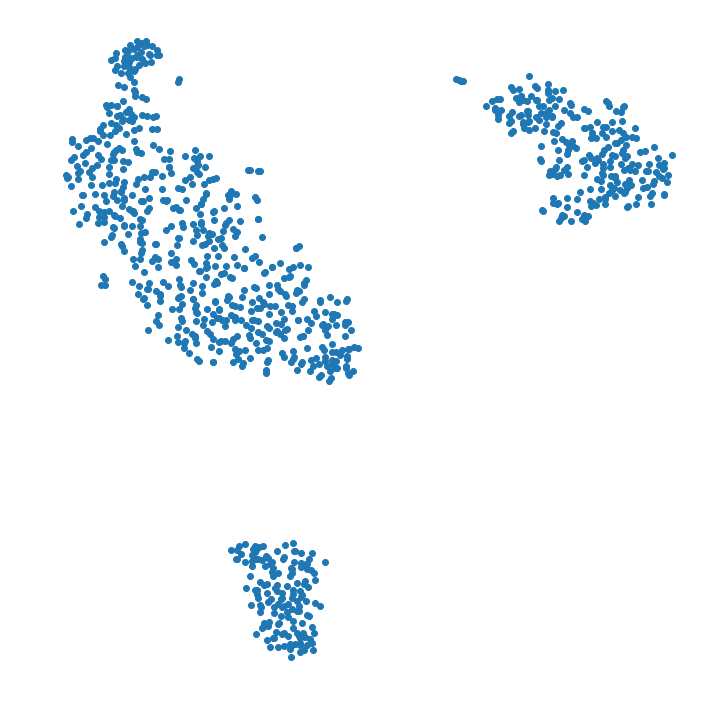

In [26]:
n_samples_tsne = 1000
full.show_t_sne(n_samples=n_samples_tsne)